In [1]:
import ast
import json
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
import warnings
from tqdm import tqdm
pd.set_option('max_columns', 100)
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
my_pal = sns.color_palette(n_colors=10)

In [2]:
# Read in the data CSV files
train = pd.read_csv('../input/data-science-bowl-2019/train.csv')
train_labels = pd.read_csv('../input/data-science-bowl-2019/train_labels.csv')
test = pd.read_csv('../input/data-science-bowl-2019/test.csv')
specs = pd.read_csv('../input/data-science-bowl-2019/specs.csv')
ss = pd.read_csv('../input/data-science-bowl-2019/sample_submission.csv')

In [3]:
print("train.csv shape: ", train.shape)
print("train_labels.csv shape: ", train_labels.shape)
print("test.csv shape: ", test.shape)
print("specs.csv shape: ", specs.shape)

train.csv shape:  (11341042, 11)
train_labels.csv shape:  (17690, 7)
test.csv shape:  (1156414, 11)
specs.csv shape:  (386, 3)


In [4]:
train_ = train.sample(1000000) # sample for efficient plot

## train.csv

- event_id - Randomly generated unique identifier for the event type. Maps to event_id column in specs table.
- game_session - Randomly generated unique identifier grouping events within a single game or video play session.
- timestamp - Client-generated datetime
- event_data - Semi-structured JSON formatted string containing the events parameters. Default fields are: event_count, event_code, and game_time; otherwise fields are determined by the event type.
- installation_id - Randomly generated unique identifier grouping game sessions within a single installed application instance.
- event_count - Incremental counter of events within a game session (offset at 1). Extracted from event_data.
- event_code - Identifier of the event 'class'. Unique per game, but may be duplicated across games. E.g. event code '2000' always identifies the 'Start Game' event for all games. Extracted from event_data.
- game_time - Time in milliseconds since the start of the game session. Extracted from event_data.
- title - Title of the game or video.
- type - Media type of the game or video. Possible values are: 'Game', 'Assessment', 'Activity', 'Clip'.
- world - The section of the application the game or video belongs to. Helpful to identify the educational curriculum goals of the media. Possible values are: 'NONE' (at the app's start screen), TREETOPCITY' (Length/Height), 'MAGMAPEAK' (Capacity/Displacement), 'CRYSTALCAVES' (Weight).

In [5]:
# because there are installation_ids which don't include assessments, these examples are removed.
# to remove data which never took assessments
keep_id = train[train.type == "Assessment"][['installation_id']].drop_duplicates()
train = pd.merge(train, keep_id, on="installation_id", how="inner")

In [6]:
train.head(10)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,34ba1a28d02ba8ba,2019-08-06T04:57:18.904Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,4b57c9a59474a1b9,2019-08-06T04:57:45.301Z,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,2b9d5af79bcdb79f,2019-08-06T04:58:14.538Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,2b9d5af79bcdb79f,2019-08-06T04:58:14.615Z,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:16.680Z,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK
5,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:18.474Z,"{""coordinates"":{""x"":863,""y"":237,""stage_width"":...",0006a69f,4,4070,3937,Sandcastle Builder (Activity),Activity,MAGMAPEAK
6,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:19.365Z,"{""coordinates"":{""x"":817,""y"":617,""stage_width"":...",0006a69f,5,4070,4820,Sandcastle Builder (Activity),Activity,MAGMAPEAK
7,1bb5fbdb,2b9d5af79bcdb79f,2019-08-06T04:58:21.490Z,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,6,3110,6954,Sandcastle Builder (Activity),Activity,MAGMAPEAK
8,1325467d,2b9d5af79bcdb79f,2019-08-06T04:58:22.732Z,"{""coordinates"":{""x"":809,""y"":180,""stage_width"":...",0006a69f,7,4070,8187,Sandcastle Builder (Activity),Activity,MAGMAPEAK
9,5e812b27,2b9d5af79bcdb79f,2019-08-06T04:58:23.295Z,"{""size"":0,""coordinates"":{""x"":782,""y"":207,""stag...",0006a69f,8,4030,8745,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8294138 entries, 0 to 8294137
Data columns (total 11 columns):
event_id           object
game_session       object
timestamp          object
event_data         object
installation_id    object
event_count        int64
event_code         int64
game_time          int64
title              object
type               object
world              object
dtypes: int64(3), object(8)
memory usage: 759.4+ MB


In [8]:
train.describe()

,event_count,event_code,game_time
count,8.294138e+06,8.294138e+06,8.294138e+06
mean,9.881407e+01,3.511168e+03,1.697724e+05
std,1.324557e+02,6.786188e+02,1.054264e+06
min,1.000000e+00,2.000000e+03,0.000000e+00
25%,2.400000e+01,3.021000e+03,2.926700e+04
50%,5.800000e+01,4.020000e+03,6.971500e+04
75%,1.220000e+02,4.035000e+03,1.492790e+05
max,3.182000e+03,5.010000e+03,3.069102e+08


In [9]:
train.isnull().sum() # no missing values in all the datasets

event_id           0
game_session       0
timestamp          0
event_data         0
installation_id    0
event_count        0
event_code         0
game_time          0
title              0
type               0
world              0
dtype: int64

In [10]:
# to check if event_id & game_session are randomly gegerated
train['event_id_as_int'] = train['event_id'].apply(lambda x: int(x, 16))
train['game_session_as_int'] = train['game_session'].apply(lambda x: int(x, 16))

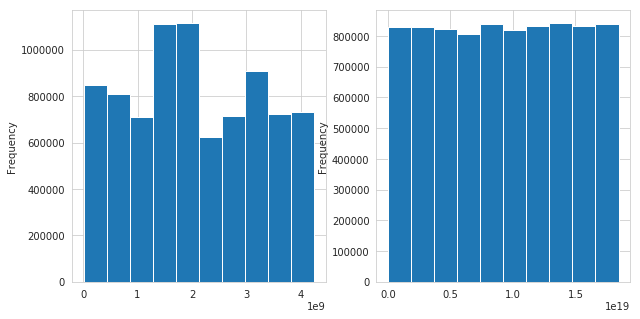

In [11]:
# However, nothing intertesting is showed.
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
train['event_id_as_int'].plot(kind="hist")
plt.subplot(1,2,2)
train['game_session_as_int'].plot(kind="hist")

In [12]:
# Format and make date / hour features
train['timestamp'] = pd.to_datetime(train['timestamp'])
train['date'] = train['timestamp'].dt.date
train['hour'] = train['timestamp'].dt.hour
train['weekday_name'] = train['timestamp'].dt.weekday_name
# Same for test
test['timestamp'] = pd.to_datetime(test['timestamp'])
test['date'] = test['timestamp'].dt.date
test['hour'] = test['timestamp'].dt.hour
test['weekday_name'] = test['timestamp'].dt.weekday_name

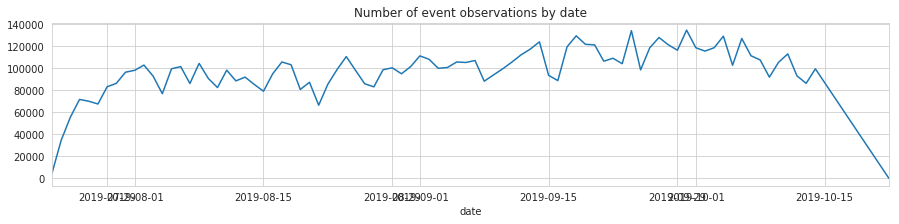

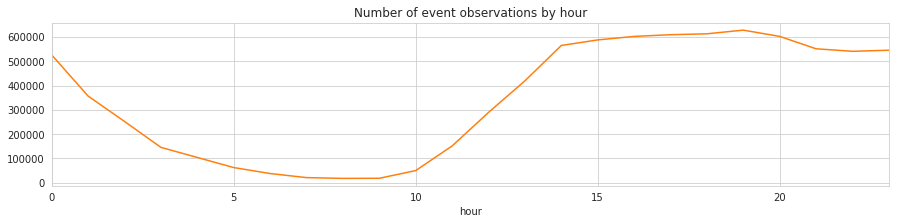

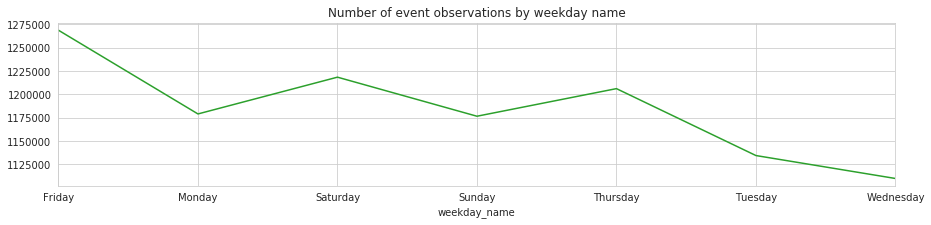

In [13]:
train.groupby('date')['event_id'].agg('count').plot(figsize=(15,3), title="Number of event observations by date", color=my_pal[0])
plt.show()
train.groupby('hour')['event_id'].agg('count').plot(figsize=(15,3), title="Number of event observations by hour", color=my_pal[1])
plt.show()
train.groupby('weekday_name')['event_id'].agg('count').plot(figsize=(15,3), title="Number of event observations by weekday name", color=my_pal[2])
plt.show()

In [14]:
# event data: which seems to have the most interesting information, however, considering the RAM limit, it's necessary to exract only the influential information.
print(train[train.event_id == "25fa8af4"].iloc[1]["event_data"])

print(json.loads(train[train.event_id == "25fa8af4"].iloc[1]["event_data"])["stumps"])

{"correct":true,"stumps":[1,2,4],"event_count":30,"game_time":18026,"event_code":4100}
[1, 2, 4]


In [15]:
# installation_id
train["installation_id"].nunique()

4242

In [16]:
# there are no installation_id's that appear in both train and test.
set(list(train.installation_id.unique())).intersection(set(list(test.installation_id.unique())))

set()

In [17]:
# date range
test['timestamp'] = pd.to_datetime(test['timestamp'])
print(f'The date range in train is: {train.timestamp.dt.date.min()} to {train.timestamp.dt.date.max()}')
print(f'The date range in test is: {test.timestamp.dt.date.min()} to {test.timestamp.dt.date.max()}')
# we are talking about a dataset that seems (randomly) split on installation_id. 
# Well actually "sort of" as Kaggle seems to have done this on installation_id's with assessments first, and added the "left-overs" with no assessments taken to the train set.

The date range in train is: 2019-07-23 to 2019-10-22
The date range in test is: 2019-07-24 to 2019-10-14


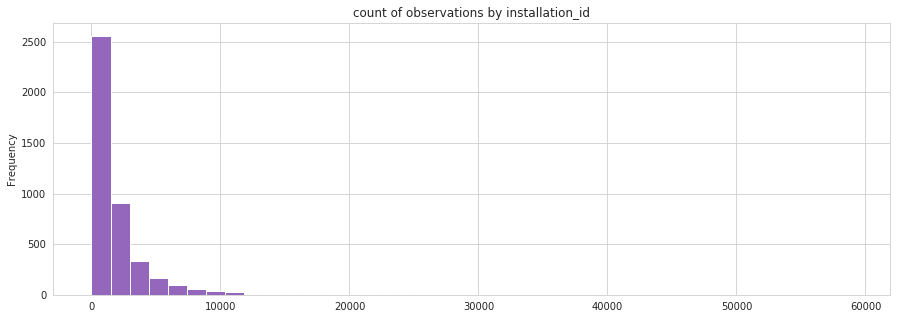

In [18]:
train.groupby('installation_id').count()['event_id'].plot(kind="hist",
          bins=40,
          color=my_pal[4],
          figsize=(15, 5), title="count of observations by installation_id")

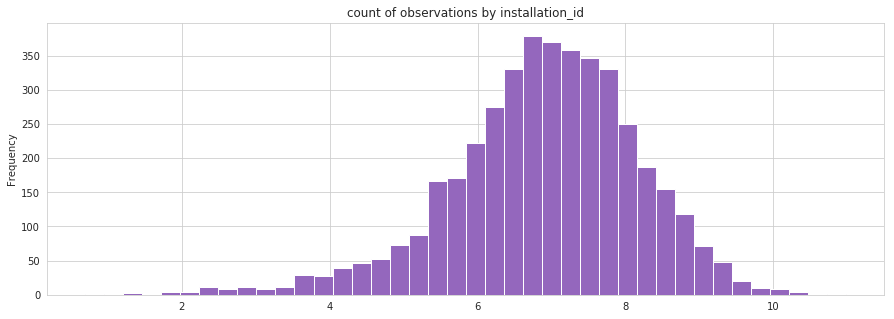

In [19]:
# take log transformation because the original data looks skewed
train.groupby('installation_id').count()['event_id'].apply(np.log1p).plot(kind="hist",
          bins=40,
          color=my_pal[4],
          figsize=(15, 5), title="count of observations by installation_id")

In [20]:
# what is the highest number of cases of installation_id
train['installation_id'].value_counts().head(3)

f1c21eda    58988
4d7d3d97    32749
d25338cb    31826
Name: installation_id, dtype: int64

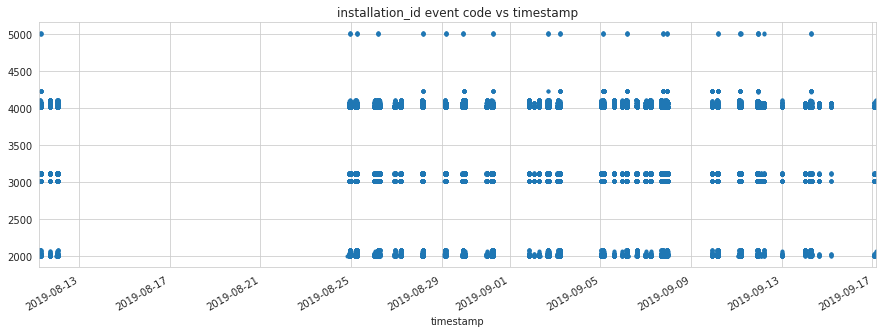

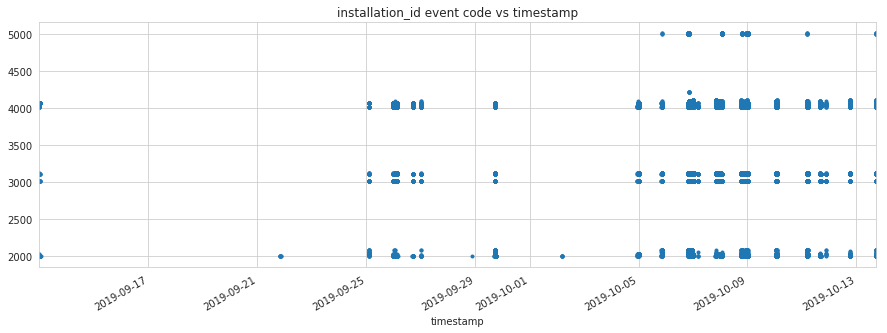

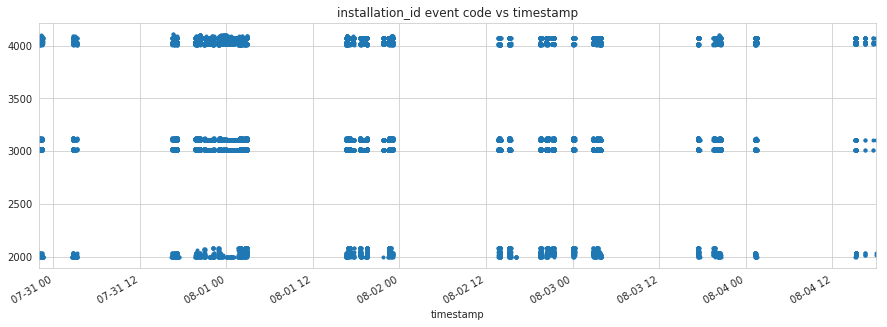

In [21]:
train.query('installation_id == "f1c21eda"').set_index("timestamp")["event_code"].plot(figsize=(15,5), title="installation_id event code vs timestamp", style=".")
plt.show()
train.query('installation_id == "4d7d3d97"').set_index("timestamp")["event_code"].plot(figsize=(15,5), title="installation_id event code vs timestamp", style=".")
plt.show()
train.query('installation_id == "d25338cb"').set_index("timestamp")["event_code"].plot(figsize=(15,5), title="installation_id event code vs timestamp", style=".")
plt.show()

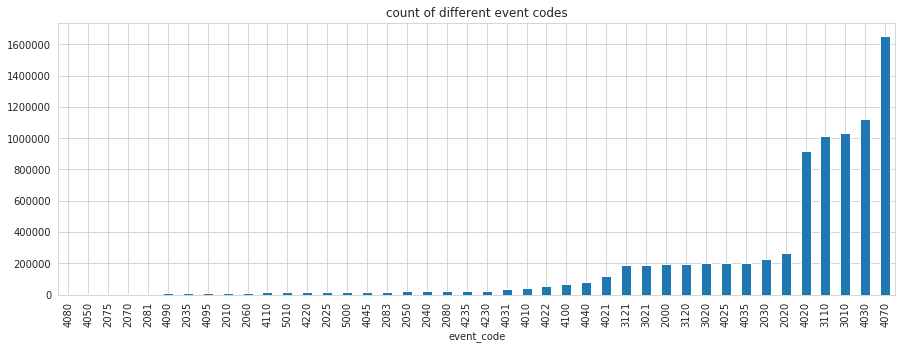

In [22]:
# event_code: looks loke dictionary format but string
train.groupby("event_code").count()["event_id"].sort_values().plot(kind="bar", figsize=(15,5), title="count of different event codes")

4070 and 4030 always come with coordinates (x, y) adn stage_width
possibly they could be marking achievement or something related to position on the screen. These events look like this
- {"coordinates":{"x":583,"y":605,"stage_width":1015,"stage_height":762},"event_count":4,"game_time":9991,"event_code":4070}


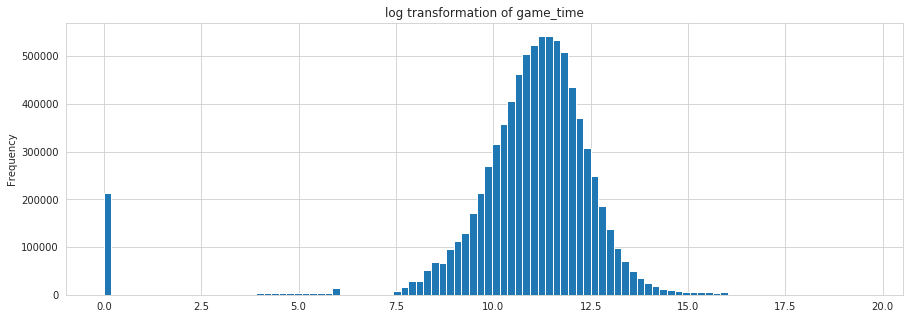

In [23]:
# game_time: almost similar to normal distribution
train["game_time"].apply(np.log1p).plot(kind="hist", figsize=(15,5), bins=100, title="log transformation of game_time")

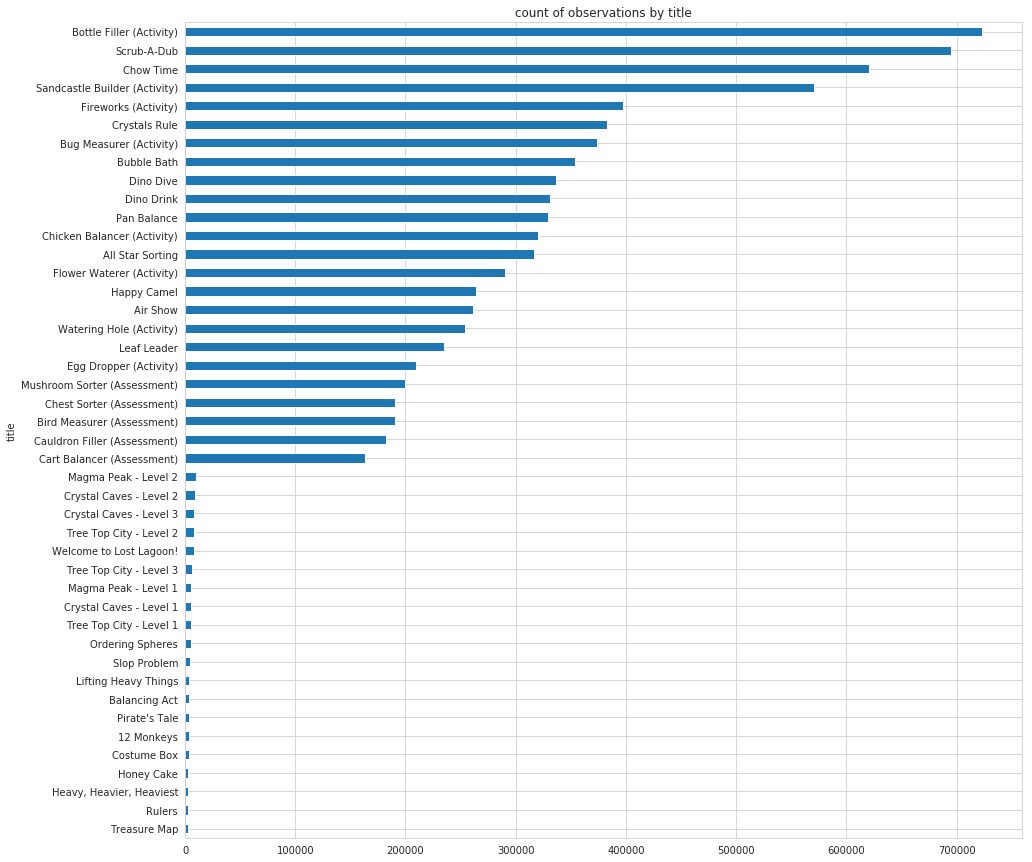

In [24]:
# game/video titles
train.groupby("title")["event_id"].count().sort_values().plot(kind="barh", title="count of observations by title", figsize=(15,15))

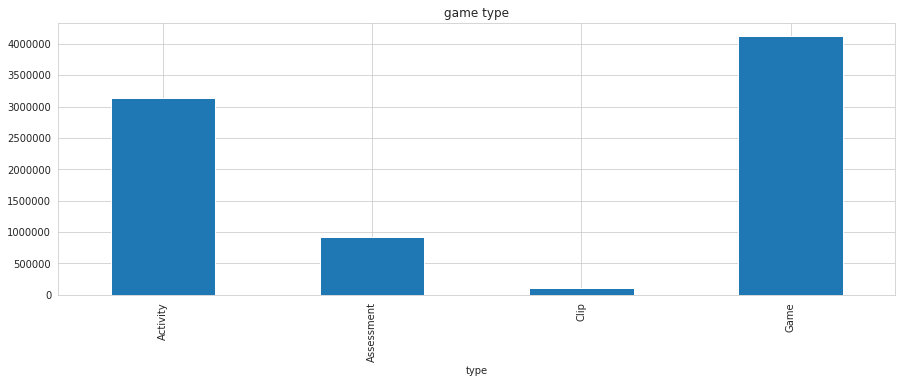

In [25]:
# game type
train.groupby("type").count()["event_id"].plot(kind="bar", figsize=(15,5), title = "game type")

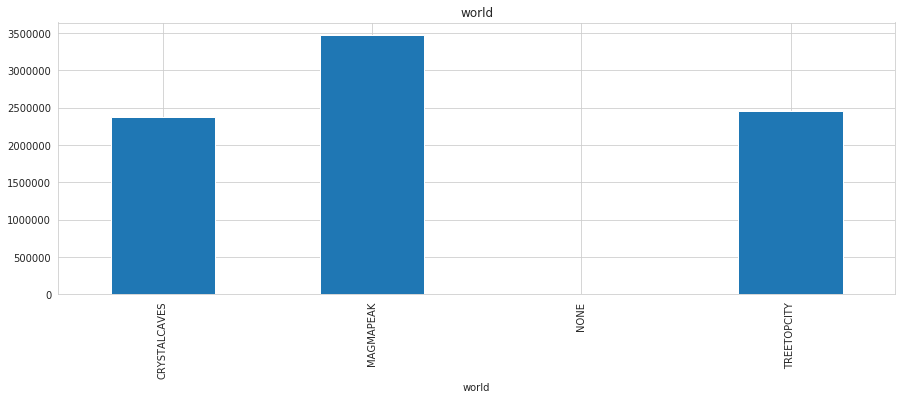

In [26]:
# world 
train.groupby("world").count()["event_id"].plot(kind="bar", figsize=(15,5), title = "world")

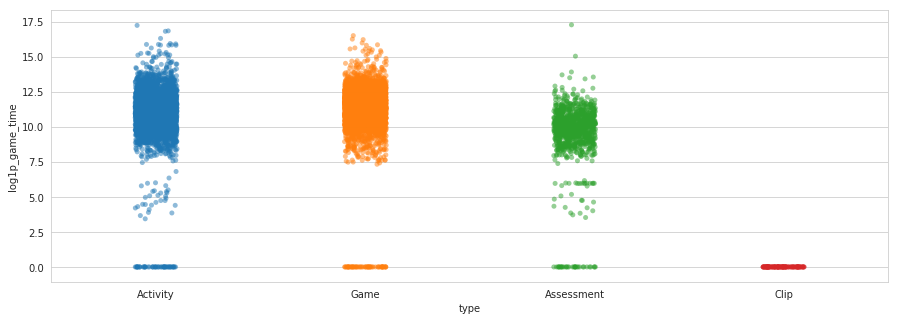

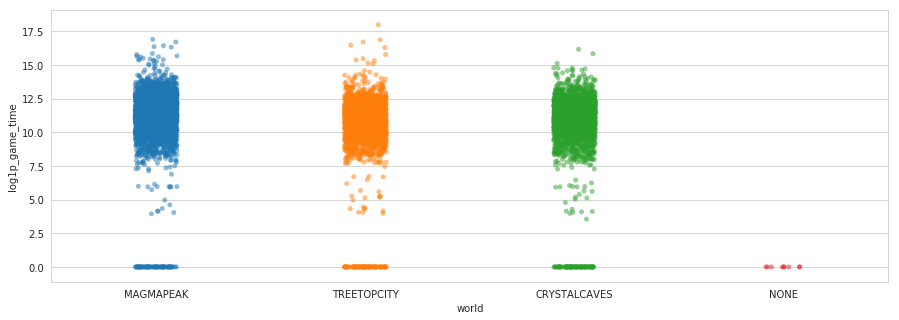

In [27]:
train["log1p_game_time"] = train["game_time"].apply(np.log1p)
fig, ax = plt.subplots(figsize=(15,5))
sns.catplot(x="type", y = "log1p_game_time", data=train.sample(10000), alpha=0.5, ax=ax)
plt.close()
fig, ax = plt.subplots(figsize=(15,5))
sns.catplot(x="world", y="log1p_game_time", data=train.sample(10000), alpha=0.5, ax=ax)
plt.close()

# train_label.csv

In [28]:
train_labels.head(5)

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [29]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17690 entries, 0 to 17689
Data columns (total 7 columns):
game_session       17690 non-null object
installation_id    17690 non-null object
title              17690 non-null object
num_correct        17690 non-null int64
num_incorrect      17690 non-null int64
accuracy           17690 non-null float64
accuracy_group     17690 non-null int64
dtypes: float64(1), int64(3), object(3)
memory usage: 967.5+ KB


In [30]:
train_labels.describe() # accuracy group is what we want to predict.

,num_correct,num_incorrect,accuracy,accuracy_group
count,17690.000000,17690.000000,17690.000000,17690.000000
mean,0.760938,1.587790,0.595810,1.885585
std,0.426523,3.058295,0.430559,1.256796
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.111111,1.000000
50%,1.000000,0.500000,0.750000,2.500000
75%,1.000000,2.000000,1.000000,3.000000
max,1.000000,85.000000,1.000000,3.000000


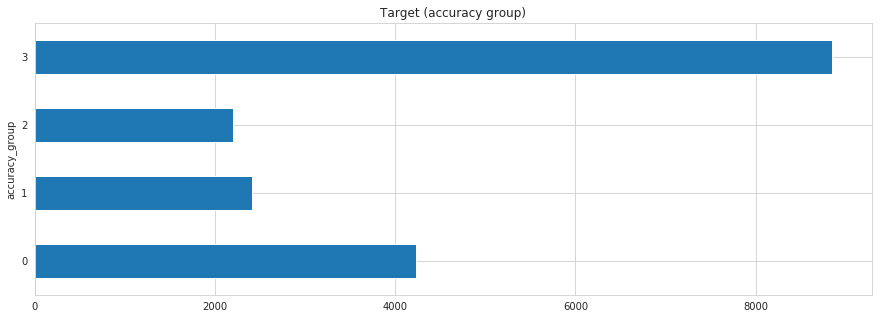

In [31]:
# target
train_labels.groupby('accuracy_group')['game_session'].count() \
    .plot(kind='barh', figsize=(15, 5), title='Target (accuracy group)')
plt.show()

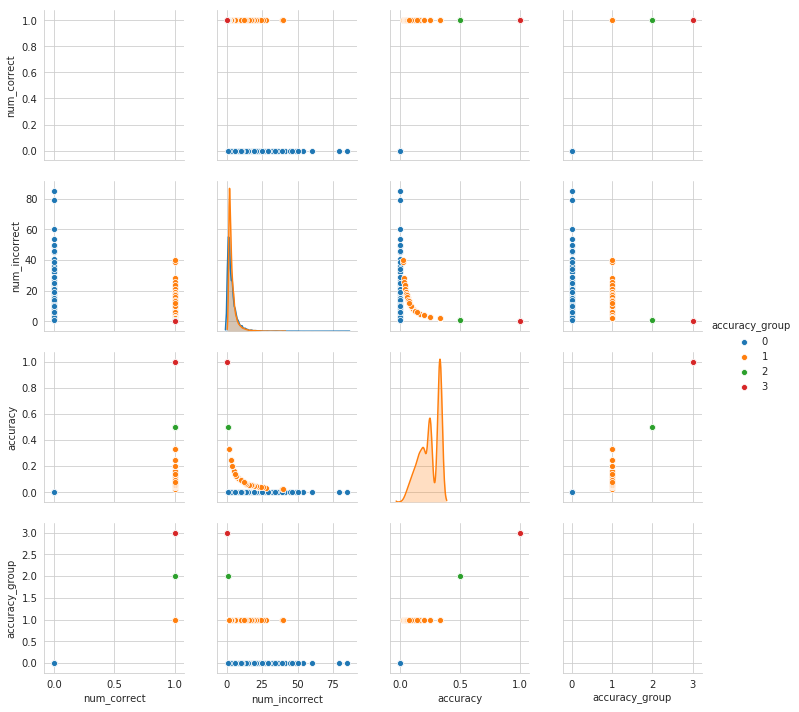

In [32]:
sns.pairplot(train_labels, hue='accuracy_group')
plt.show()

Text(0.5, 1.0, 'Counts of titles')

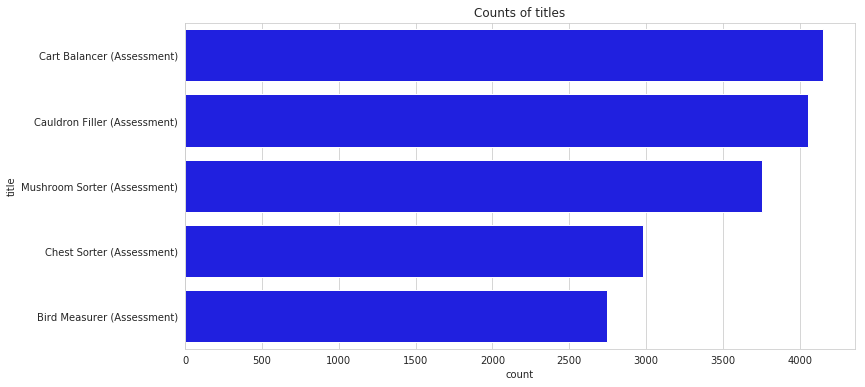

In [33]:
# count of title
plt.figure(figsize=(12,6))
sns.countplot(y="title", data=train_labels, color="blue", order = train_labels.title.value_counts().index)
plt.title("Counts of titles")

Text(0.5, 1.0, 'Counts of accuracy group')

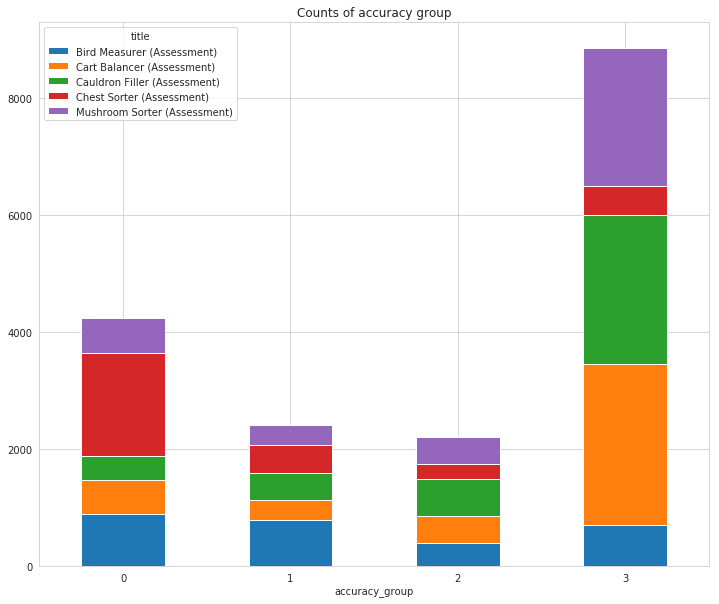

In [34]:
se = train_labels.groupby(['title', 'accuracy_group'])['accuracy_group'].count().unstack('title')
se.plot.bar(stacked=True, rot=0, figsize=(12,10))
plt.title("Counts of accuracy group")
# you can see that a lot of Chest Sorter assessments were never solved.
# Bird Measurer also seems hard with a relatively small amount solved on the first attempt.
# which means that there's difference in the difficulty of games

As the match between the train dataframe and the train_labels dataframe is not straightforward, it tried to figure out how these dataframes are to be matched by focussing on just one particular installation_id.

In [35]:
train_labels[train_labels.installation_id == "0006a69f"]

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


From Kaggle: The file train_labels.csv has been provided to show how these groups would be computed on the assessments in the training set. Assessment attempts are captured in event_code 4100 for all assessments except for Bird Measurer, which uses event_code 4110. If the attempt was correct, it contains "correct":true.

However, in the first version I already noticed that I had one attempt too many for this installation_id when mapping the rows with the train_labels for. It turns out that there are in fact also assessment attemps for Bird Measurer with event_code 4100, which should not count (see below). In this case that also makes sense as this installation_id already had a pass on the first attempt

In [36]:
train[(train.event_code == 4100) & (train.installation_id == "0006a69f") & (train.title == "Bird Measurer (Assessment)")]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,event_id_as_int,game_session_as_int,date,hour,weekday_name,log1p_game_time
2615,070a5291,a9ef3ecb3d1acc6a,2019-08-06 20:50:33.283000+00:00,"{""correct"":true,""hats"":[4,8,5],""event_count"":3...",0006a69f,30,4100,34209,Bird Measurer (Assessment),Assessment,TREETOPCITY,118117009,12245074954468117610,2019-08-06,20,Tuesday,10.440273


When we exclude the Bird Measurer/4100 rows we get the correct match with the numbers in train_labels for this installation_id (4 correct, 12 incorrect)

In [37]:
train[(train.installation_id == "0006a69f") & ((train.type == "Assessment") & (train.title == 'Bird Measurer (Assessment)') & (train.event_code == 4110) |
                                               (train.type == "Assessment") & (train.title != 'Bird Measurer (Assessment)') & (train.event_code == 4100))]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,event_id_as_int,game_session_as_int,date,hour,weekday_name,log1p_game_time
690,25fa8af4,901acc108f55a5a1,2019-08-06 05:22:32.357000+00:00,"{""correct"":true,""stumps"":[1,2,4],""event_count""...",0006a69f,44,4100,31011,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,637176564,10383836262352397729,2019-08-06,5,Tuesday,10.342130
1171,17113b36,77b8ee947eb84b4e,2019-08-06 05:35:54.898000+00:00,"{""correct"":false,""caterpillars"":[11,8,3],""even...",0006a69f,29,4110,35771,Bird Measurer (Assessment),Assessment,TREETOPCITY,387005238,8626907407776762702,2019-08-06,5,Tuesday,10.484921
1177,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:01.927000+00:00,"{""correct"":false,""caterpillars"":[11,8,11],""eve...",0006a69f,35,4110,42805,Bird Measurer (Assessment),Assessment,TREETOPCITY,387005238,8626907407776762702,2019-08-06,5,Tuesday,10.664434
1182,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:06.512000+00:00,"{""correct"":false,""caterpillars"":[11,8,5],""even...",0006a69f,40,4110,47388,Bird Measurer (Assessment),Assessment,TREETOPCITY,387005238,8626907407776762702,2019-08-06,5,Tuesday,10.766145
1187,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:09.739000+00:00,"{""correct"":false,""caterpillars"":[11,8,7],""even...",0006a69f,45,4110,50605,Bird Measurer (Assessment),Assessment,TREETOPCITY,387005238,8626907407776762702,2019-08-06,5,Tuesday,10.831825
1192,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:13.951000+00:00,"{""correct"":false,""caterpillars"":[11,8,4],""even...",0006a69f,50,4110,54822,Bird Measurer (Assessment),Assessment,TREETOPCITY,387005238,8626907407776762702,2019-08-06,5,Tuesday,10.911865
1195,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:17.407000+00:00,"{""correct"":false,""caterpillars"":[11,8,4],""even...",0006a69f,53,4110,58280,Bird Measurer (Assessment),Assessment,TREETOPCITY,387005238,8626907407776762702,2019-08-06,5,Tuesday,10.973031
1200,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:21.390000+00:00,"{""correct"":false,""caterpillars"":[11,8,2],""even...",0006a69f,58,4110,62256,Bird Measurer (Assessment),Assessment,TREETOPCITY,387005238,8626907407776762702,2019-08-06,5,Tuesday,11.039026
1205,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:26.296000+00:00,"{""correct"":false,""caterpillars"":[11,8,1],""even...",0006a69f,63,4110,67164,Bird Measurer (Assessment),Assessment,TREETOPCITY,387005238,8626907407776762702,2019-08-06,5,Tuesday,11.114908
1212,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:32.187000+00:00,"{""correct"":false,""caterpillars"":[11,8,1],""even...",0006a69f,70,4110,73056,Bird Measurer (Assessment),Assessment,TREETOPCITY,387005238,8626907407776762702,2019-08-06,5,Tuesday,11.198995


In [38]:
train[(train.installation_id == "0006a69f")]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,event_id_as_int,game_session_as_int,date,hour,weekday_name,log1p_game_time
0,27253bdc,34ba1a28d02ba8ba,2019-08-06 04:57:18.904000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,656751580,3799377998233970874,2019-08-06,4,Tuesday,0.000000
1,27253bdc,4b57c9a59474a1b9,2019-08-06 04:57:45.301000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,656751580,5429029588815880633,2019-08-06,4,Tuesday,0.000000
2,77261ab5,2b9d5af79bcdb79f,2019-08-06 04:58:14.538000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK,1998985909,3142768134491846559,2019-08-06,4,Tuesday,0.000000
3,b2dba42b,2b9d5af79bcdb79f,2019-08-06 04:58:14.615000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK,3000738859,3142768134491846559,2019-08-06,4,Tuesday,3.401197
4,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:16.680000+00:00,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK,321209981,3142768134491846559,2019-08-06,4,Tuesday,7.667626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3796,832735e1,0721802df0531701,2019-08-29 16:33:53.227000+00:00,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,11,3010,23145,Dino Dive,Game,MAGMAPEAK,2200384993,513832767290808065,2019-08-29,16,Thursday,10.049577
3797,ab3136ba,0721802df0531701,2019-08-29 16:33:56.880000+00:00,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,12,3110,26804,Dino Dive,Game,MAGMAPEAK,2872129210,513832767290808065,2019-08-29,16,Thursday,10.196344
3798,832735e1,0721802df0531701,2019-08-29 16:34:11.881000+00:00,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,13,3010,41805,Dino Dive,Game,MAGMAPEAK,2200384993,513832767290808065,2019-08-29,16,Thursday,10.640795
3799,ab3136ba,0721802df0531701,2019-08-29 16:34:15.480000+00:00,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,14,3110,45405,Dino Dive,Game,MAGMAPEAK,2872129210,513832767290808065,2019-08-29,16,Thursday,10.723400


Now the question arises: Could there be installation_id's who did assessments (we have already taken out the ones who never took one), but without results in the train_labels? As you can see below, yes there are 628 examples.

In [39]:
train[~train.installation_id.isin(train_labels.installation_id.unique())].installation_id.nunique()

628

In [40]:
### remove unnecessary data
train = train[train.installation_id.isin(train_labels.installation_id.unique())]
train.shape

(7734558, 17)

In [41]:
print(train_labels.shape[0])
print(train_labels.installation_id.nunique())

17690
3614


In [42]:
%%time
# extract information from event_data
# version
train["event_data"].apply(lambda x: json.loads(x)["version"] if "\"version\"" in x else "None")
# media type
train["media_type"] = train["event_data"].apply(lambda x: json.loads(x)["media_type"] if "\"media_type\"" in x else "None")
# level
train["level"] = train["event_data"].apply(lambda x: json.loads(x)["level"] if "\"level\"" in x else "None")
# duration
train["duration"] = train["event_data"].apply(lambda x: json.loads(x)["duration"] if "\"duration\"" in x else "None")
# identifier
train["identifier"] = train["event_data"].apply(lambda x: json.loads(x)["identifier"] if "\"identifier\"" in x else "None")
# **
train["stumps"] = train["event_data"].apply(lambda x: np.sum(json.loads(x)["stumps"]) if "\"stumps\"" in x else "None")
# **
train["caterpillars"] = train["event_data"].apply(lambda x: np.sum(json.loads(x)["caterpillars"]) if "\"caterpillars\"" in x else "None")
# **
train["click"] = train["event_data"].apply(lambda x: 1 if "\"coordinates\"" in x else 0)

CPU times: user 1min 54s, sys: 1.64 s, total: 1min 55s
Wall time: 1min 55s


In [43]:
print("media type:", train["media_type"].value_counts()["None"] / train.shape[0])
print("identifier:", train["identifier"].value_counts()["None"] / train.shape[0])

media type: 0.6584637415609269
identifier: 0.6584637415609269


In [44]:
train[train.type=="Assessment"]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,event_id_as_int,game_session_as_int,date,hour,weekday_name,log1p_game_time,media_type,level,duration,identifier,stumps,caterpillars,click
647,3bfd1a65,901acc108f55a5a1,2019-08-06 05:22:01.344000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,1006443109,10383836262352397729,2019-08-06,5,Tuesday,0.000000,None,None,None,None,None,None,0
648,db02c830,901acc108f55a5a1,2019-08-06 05:22:01.400000+00:00,"{""event_count"":2,""game_time"":37,""event_code"":2...",0006a69f,2,2025,37,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,3674392624,10383836262352397729,2019-08-06,5,Tuesday,3.637586,None,None,None,None,None,None,0
649,a1e4395d,901acc108f55a5a1,2019-08-06 05:22:01.403000+00:00,"{""description"":""Pull three mushrooms out of th...",0006a69f,3,3010,37,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2716088669,10383836262352397729,2019-08-06,5,Tuesday,3.637586,audio,None,None,Dot_PullMushrooms,None,None,0
650,a52b92d5,901acc108f55a5a1,2019-08-06 05:22:05.242000+00:00,"{""description"":""Pull three mushrooms out of th...",0006a69f,4,3110,3901,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2771096277,10383836262352397729,2019-08-06,5,Tuesday,8.269245,audio,None,3864,Dot_PullMushrooms,None,None,0
651,a1e4395d,901acc108f55a5a1,2019-08-06 05:22:05.244000+00:00,"{""description"":""To pick a mushroom, pull it ou...",0006a69f,5,3010,3901,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2716088669,10383836262352397729,2019-08-06,5,Tuesday,8.269245,audio,None,None,Dot_PickFinger,None,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8294133,28520915,5448d652309a6324,2019-09-22 02:07:27.562000+00:00,"{""misses"":1,""prompt"":""holds least"",""mode"":""sel...",ffeb0b1b,58,2030,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,676464917,6073339746000200484,2019-09-22,2,Sunday,11.113865,None,None,7067,None,None,None,0
8294134,91561152,5448d652309a6324,2019-09-22 02:07:27.562000+00:00,"{""bucket"":1,""buckets_placed"":[3,1,2],""target_b...",ffeb0b1b,57,4025,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,2438336850,6073339746000200484,2019-09-22,2,Sunday,11.113865,None,None,None,None,None,None,1
8294135,d3268efa,5448d652309a6324,2019-09-22 02:07:27.566000+00:00,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",ffeb0b1b,59,3021,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,3542519546,6073339746000200484,2019-09-22,2,Sunday,11.113865,audio,None,None,Dot_Awesome,None,None,0
8294136,b5053438,5448d652309a6324,2019-09-22 02:07:28.311000+00:00,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",ffeb0b1b,60,3121,67847,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,3037017144,6073339746000200484,2019-09-22,2,Sunday,11.125025,audio,None,753,Dot_Awesome,None,None,0


In [45]:
train.iloc[829414, :]["event_data"]

'{"coordinates":{"x":215,"y":582,"stage_width":1015,"stage_height":762},"event_count":36,"game_time":26867,"event_code":4070}'

In [46]:
train[train.type=="Assessment"].iloc[7]["event_data"]

'{"description":"That\'s one!","identifier":"Dot_ThatsOne","media_type":"audio","total_duration":600,"event_count":8,"game_time":6475,"event_code":3021}'

# test.csv

In [47]:
test.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,hour,weekday_name
0,27253bdc,0ea9ecc81a565215,2019-09-10 16:50:24.910000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,2019-09-10,16,Tuesday
1,27253bdc,c1ea43d8b8261d27,2019-09-10 16:50:55.503000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,2019-09-10,16,Tuesday
2,27253bdc,7ed86c6b72e725e2,2019-09-10 16:51:51.805000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK,2019-09-10,16,Tuesday
3,27253bdc,7e516ace50e7fe67,2019-09-10 16:53:12.825000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES,2019-09-10,16,Tuesday
4,7d093bf9,a022c3f60ba547e7,2019-09-10 16:54:12.115000+00:00,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES,2019-09-10,16,Tuesday


In [48]:
test.shape

(1156414, 14)

In [49]:
print(test.installation_id.nunique())
print(ss.shape[0])
# So we have 1.1 million rows on a thousand unique installation_ids in the test set. 
# Below, you can see that we have this same amount of rows in the sample submission.
# This means that there are no installation_ids without assessment in the test set indeed.

1000
1000


In [50]:
test.installation_id.unique()

array(['00abaee7', '01242218', '017c5718', '01a44906', '01bc6cb6',
       '02256298', '0267757a', '027e7ce5', '02a29f99', '0300c576',
       '03885368', '03ac279b', '03e33699', '048e7427', '04a7bc3f',
       '04d31500', '0500e23b', '0512bf0e', '0525589b', '05488e26',
       '05771bba', '05b82cf5', '05e17e19', '0617500d', '068ae11f',
       '0754f13b', '07749e99', '08611cc8', '08671ec7', '0889b0ae',
       '090fe325', '0937340d', '09aaaf83', '09aefe80', '0a126293',
       '0a2a77b2', '0a4c0f78', '0af94ba5', '0b24b6ac', '0b607c82',
       '0d5735f2', '0d735146', '0d7752d3', '0dd670e9', '0de6863d',
       '0e514571', '0e718764', '0ea27b66', '0f584054', '0f7116a6',
       '101999d8', '101d16f5', '108044a0', '109ad724', '10acf963',
       '1121f331', '1181ce7c', '11fa34d0', '125a3d09', '12771ee9',
       '1294d68e', '12bcbbce', '13629687', '138a2ecc', '13a0754c',
       '13bcaf23', '13cf3fc0', '13d608cb', '140087ce', '140ea7a3',
       '1423dc8f', '14cdc97f', '153f087c', '1594c19e', '15d869

In [51]:
# last row in each installation_id data is always assessment
#for i in list(test.installation_id.unique()): 
#    print(test[test.installation_id == i].iloc[-1]["type"])

In [52]:
test[test.installation_id == "01242218"]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,hour,weekday_name
868,27253bdc,8f8b93e30590f263,2019-09-22 20:58:41.078000+00:00,"{""event_code"": 2000, ""event_count"": 1}",01242218,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,2019-09-22,20,Sunday
869,27253bdc,7f4ff05e14cea4ea,2019-09-22 20:59:09.640000+00:00,"{""event_code"": 2000, ""event_count"": 1}",01242218,1,2000,0,Tree Top City - Level 1,Clip,TREETOPCITY,2019-09-22,20,Sunday
870,27253bdc,a09b503c4b8d7000,2019-09-22 20:59:42.371000+00:00,"{""event_code"": 2000, ""event_count"": 1}",01242218,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,2019-09-22,20,Sunday
871,77261ab5,ffec6761763be29e,2019-09-22 21:00:12.227000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",01242218,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-09-22,21,Sunday
872,b2dba42b,ffec6761763be29e,2019-09-22 21:00:12.331000+00:00,"{""description"":""Let's build a sandcastle! Firs...",01242218,2,3010,75,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-09-22,21,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3582,36fa3ebe,b721d4026ce65fd9,2019-10-09 20:22:47.259000+00:00,"{""duration"":10217,""misses"":0,""round"":3,""event_...",01242218,59,2030,68691,Happy Camel,Game,CRYSTALCAVES,2019-10-09,20,Wednesday
3583,c7fe2a55,b721d4026ce65fd9,2019-10-09 20:22:49.167000+00:00,"{""description"":""You have amazing powers!"",""ide...",01242218,60,3021,70557,Happy Camel,Game,CRYSTALCAVES,2019-10-09,20,Wednesday
3584,a8a78786,b721d4026ce65fd9,2019-10-09 20:22:52.930000+00:00,"{""description"":""You have amazing powers!"",""ide...",01242218,61,3121,74358,Happy Camel,Game,CRYSTALCAVES,2019-10-09,20,Wednesday
3585,d51b1749,b721d4026ce65fd9,2019-10-09 20:22:55.447000+00:00,"{""movie_id"":""Outro"",""duration"":10466,""descript...",01242218,62,2080,76879,Happy Camel,Game,CRYSTALCAVES,2019-10-09,20,Wednesday


In [53]:
# it doesn't mean that there's only one assessment example.
test[test.installation_id == "01242218"]["type"].value_counts()

Activity      1356
Game          1089
Assessment     245
Clip            29
Name: type, dtype: int64

# specs.csv

In [54]:
specs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386 entries, 0 to 385
Data columns (total 3 columns):
event_id    386 non-null object
info        386 non-null object
args        386 non-null object
dtypes: object(3)
memory usage: 9.2+ KB


In [55]:
specs.describe()

,event_id,info,args
count,386,386,386
unique,386,168,191
top,65a38bf7,This event occurs when the player clicks on th...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
freq,1,17,25


In [56]:
specs.head(5)

,event_id,info,args
0,2b9272f4,The end of system-initiated feedback (Correct)...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
1,df4fe8b6,The end of system-initiated feedback (Incorrec...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
2,3babcb9b,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
3,7f0836bf,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
4,ab3136ba,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."


In [57]:
## what is writtern in info? なぜ異なるevent_id同じinfoが書かれているのか。argが異なる？
for i in range(specs["info"].nunique()):
    print(i, specs["info"].unique()[i])
    print("")

0 The end of system-initiated feedback (Correct) event occurs when the game finishes delivering feedback to the player in response to a correct round attempt (pressing the go button with the correct answer). It contains information that describes the duration and content of the instruction, and will likely occur in conjunction with a beat round event. These events are used to determine the effectiveness of the feedback. We can answer questions like, "how much time elapsed while the game was presenting feedback?"

1 The end of system-initiated feedback (Incorrect) event occurs when the game finishes delivering feedback to the player in response to an incorrect round attempt (pressing the go button with the incorrect answer). It contains information that describes the content of the instruction. These events are used to determine the effectiveness of the feedback. We can answer questions like, "how much time elapsed while the game was presenting feedback?"

2 The end of system-initiated 

In [58]:
for i in range(specs["args"].nunique()): # train, testのevent_data変数に書かれている情報を示している。
    print(i, specs["args"].unique()[i])
    print("")

0 [{"name":"game_time","type":"int","info":"millisecond count since start of game"},{"name":"round","type":"int","info":"number of the current round when the event takes place or 0 if no round"},{"name":"level","type":"int","info":"number of the current level when the event takes place or 0 if no level"},{"name":"description","type":"string","info":"the text or description of the instruction"},{"name":"identifier","type":"string","info":"a unique identifier for this piece of instruction"},{"name":"media_type","type":"string","info":"the type of media that has just played:\n'audio' || 'animation' || 'other'"},{"name":"duration","type":"int","info":"the duration of the media playback in milliseconds"},{"name":"event_count","type":"int","info":"session event counter"},{"name":"event_code","type":"int","info":"event class identifier"}]

1 [{"name":"game_time","type":"int","info":"millisecond count since start of game"},{"name":"description","type":"string","info":"the text or description o

# connections between train.csv and specs.csv

In [59]:
train[train.event_id == "2b9272f4"].iloc[0]["event_data"]

'{"description":"Everybody\'s got a tub that\'s just the right size. All right!","identifier":"tub_success","media_type":"animation","duration":4900,"level":1,"round":2,"event_count":16,"game_time":19711,"event_code":3121}'

In [60]:
specs[specs.event_id == "2b9272f4"]["args"][0][1:-1]

'{"name":"game_time","type":"int","info":"millisecond count since start of game"},{"name":"round","type":"int","info":"number of the current round when the event takes place or 0 if no round"},{"name":"level","type":"int","info":"number of the current level when the event takes place or 0 if no level"},{"name":"description","type":"string","info":"the text or description of the instruction"},{"name":"identifier","type":"string","info":"a unique identifier for this piece of instruction"},{"name":"media_type","type":"string","info":"the type of media that has just played:\\n\'audio\' || \'animation\' || \'other\'"},{"name":"duration","type":"int","info":"the duration of the media playback in milliseconds"},{"name":"event_count","type":"int","info":"session event counter"},{"name":"event_code","type":"int","info":"event class identifier"}'

In [61]:
#dic = ast.literal_eval(specs[specs.event_id == "2b9272f4"]["args"][0][1:-1])
dic = ast.literal_eval(train[train.event_id == "2b9272f4"].iloc[0]["event_data"])
dic

{'description': "Everybody's got a tub that's just the right size. All right!",
 'identifier': 'tub_success',
 'media_type': 'animation',
 'duration': 4900,
 'level': 1,
 'round': 2,
 'event_count': 16,
 'game_time': 19711,
 'event_code': 3121}

In [62]:
for i in range(train.shape[0]):
    dic = ast.literal_eval(train.iloc[i]["event_data"])
    print(dic)

{'event_code': 2000, 'event_count': 1}
{'event_code': 2000, 'event_count': 1}
{'version': '1.0', 'event_count': 1, 'game_time': 0, 'event_code': 2000}
{'description': "Let's build a sandcastle! First, fill up your mold with sand! You can use the shovel here. The mold gives the sand its shape!", 'identifier': 'Dot_LetsSandcastle,Dot_FillMold,Dot_MoldShape', 'media_type': 'audio', 'total_duration': 6758, 'event_count': 2, 'game_time': 29, 'event_code': 3010}
{'coordinates': {'x': 273, 'y': 650, 'stage_width': 1015, 'stage_height': 762}, 'event_count': 3, 'game_time': 2137, 'event_code': 4070}
{'coordinates': {'x': 863, 'y': 237, 'stage_width': 1015, 'stage_height': 762}, 'event_count': 4, 'game_time': 3937, 'event_code': 4070}
{'coordinates': {'x': 817, 'y': 617, 'stage_width': 1015, 'stage_height': 762}, 'event_count': 5, 'game_time': 4820, 'event_code': 4070}
{'description': "Let's build a sandcastle! First, fill up your mold with sand! You can use the shovel here. The mold gives the s

ValueError: malformed node or string: <_ast.Name object at 0x7f48f33bf7f0>

# connections between train.csv and train_labls.csv 

In [63]:
set(train.columns) & set(train_labels.columns)

{'game_session', 'installation_id', 'title'}

In [64]:
train_labels[train_labels.installation_id == "0006a69f"]

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


In [65]:
tmp = train[(train.installation_id == "0006a69f") & ((train.type == "Assessment") & (train.title == 'Bird Measurer (Assessment)') & (train.event_code == 4110) |
                                               (train.type == "Assessment") & (train.title != 'Bird Measurer (Assessment)') & (train.event_code == 4100))]

In [66]:
tmp.reset_index(drop=True)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,event_id_as_int,game_session_as_int,date,hour,weekday_name,log1p_game_time,media_type,level,duration,identifier,stumps,caterpillars,click
0,25fa8af4,901acc108f55a5a1,2019-08-06 05:22:32.357000+00:00,"{""correct"":true,""stumps"":[1,2,4],""event_count""...",0006a69f,44,4100,31011,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,637176564,10383836262352397729,2019-08-06,5,Tuesday,10.342130,None,None,None,None,7,None,0
1,17113b36,77b8ee947eb84b4e,2019-08-06 05:35:54.898000+00:00,"{""correct"":false,""caterpillars"":[11,8,3],""even...",0006a69f,29,4110,35771,Bird Measurer (Assessment),Assessment,TREETOPCITY,387005238,8626907407776762702,2019-08-06,5,Tuesday,10.484921,None,None,None,None,None,22,0
2,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:01.927000+00:00,"{""correct"":false,""caterpillars"":[11,8,11],""eve...",0006a69f,35,4110,42805,Bird Measurer (Assessment),Assessment,TREETOPCITY,387005238,8626907407776762702,2019-08-06,5,Tuesday,10.664434,None,None,None,None,None,30,0
3,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:06.512000+00:00,"{""correct"":false,""caterpillars"":[11,8,5],""even...",0006a69f,40,4110,47388,Bird Measurer (Assessment),Assessment,TREETOPCITY,387005238,8626907407776762702,2019-08-06,5,Tuesday,10.766145,None,None,None,None,None,24,0
4,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:09.739000+00:00,"{""correct"":false,""caterpillars"":[11,8,7],""even...",0006a69f,45,4110,50605,Bird Measurer (Assessment),Assessment,TREETOPCITY,387005238,8626907407776762702,2019-08-06,5,Tuesday,10.831825,None,None,None,None,None,26,0
5,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:13.951000+00:00,"{""correct"":false,""caterpillars"":[11,8,4],""even...",0006a69f,50,4110,54822,Bird Measurer (Assessment),Assessment,TREETOPCITY,387005238,8626907407776762702,2019-08-06,5,Tuesday,10.911865,None,None,None,None,None,23,0
6,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:17.407000+00:00,"{""correct"":false,""caterpillars"":[11,8,4],""even...",0006a69f,53,4110,58280,Bird Measurer (Assessment),Assessment,TREETOPCITY,387005238,8626907407776762702,2019-08-06,5,Tuesday,10.973031,None,None,None,None,None,23,0
7,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:21.390000+00:00,"{""correct"":false,""caterpillars"":[11,8,2],""even...",0006a69f,58,4110,62256,Bird Measurer (Assessment),Assessment,TREETOPCITY,387005238,8626907407776762702,2019-08-06,5,Tuesday,11.039026,None,None,None,None,None,21,0
8,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:26.296000+00:00,"{""correct"":false,""caterpillars"":[11,8,1],""even...",0006a69f,63,4110,67164,Bird Measurer (Assessment),Assessment,TREETOPCITY,387005238,8626907407776762702,2019-08-06,5,Tuesday,11.114908,None,None,None,None,None,20,0
9,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:32.187000+00:00,"{""correct"":false,""caterpillars"":[11,8,1],""even...",0006a69f,70,4110,73056,Bird Measurer (Assessment),Assessment,TREETOPCITY,387005238,8626907407776762702,2019-08-06,5,Tuesday,11.198995,None,None,None,None,None,20,0


In [67]:
tmp.game_session.value_counts()

77b8ee947eb84b4e    11
9501794defd84e4d     2
a9ef3ecb3d1acc6a     1
6bdf9623adc94d89     1
901acc108f55a5a1     1
Name: game_session, dtype: int64

# sample_submission.csv

In [68]:
ss.head()

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3


In [69]:
train.groupby("game_session").count()

,event_id,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,event_id_as_int,game_session_as_int,date,hour,weekday_name,log1p_game_time,media_type,level,duration,identifier,stumps,caterpillars,click
game_session,,,,,,,,,,,,,,,,,,,,,,,
000050630c4b081b,109,109,109,109,109,109,109,109,109,109,109,109,109,109,109,109,109,109,109,109,109,109,109
00005be8058d8e35,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
0000d473b2f78883,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75,75
0000e00444c302d9,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
00011d7f4b48ed4b,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffda980b07029a3,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26
fffe19a8d3973f9d,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
fffe897c0216edaf,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


# ideas of feature engineering

In [70]:
%%time
# encode of game/video titles
all_titles = list(set(train['title'].unique()).union(set(test['title'].unique())))
titles_map = dict(zip(all_titles, np.arange(len(all_titles))))
train['title'] = train['title'].map(titles_map)
test['title'] = test['title'].map(titles_map)
train_labels['title'] = train_labels['title'].map(titles_map)

# connect between game/video titles and event_code about assessment
title_assess_code = dict(zip(titles_map.values(), (4100*np.ones(len(titles_map))).astype('int')))
title_assess_code[titles_map['Bird Measurer (Assessment)']] = 4110

# data type change of games
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

CPU times: user 4.89 s, sys: 944 ms, total: 5.83 s
Wall time: 5.73 s


In [71]:
def get_data(user_sample, test_set=False):
    last_activity = 0
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy=0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0 
    accumulated_actions = 0
    counter = 0
    durations = []
    for i, session in user_sample.groupby('game_session', sort=False):# for each game_session in installation_id
        session_type = session['type'].iloc[0] # because there's only one type, the 0th element is exracted
        session_title = session['title'].iloc[0]
        if test_set == True:
            second_condition = True
        else:
            if len(session)>1:
                second_condition = True
            else:
                second_condition= False
        #print(session['type'].nunique())
        #print(session.game_session.unique(), second_condition)
        if (session_type == 'Assessment') & (second_condition):
            all_attempts = session.query(f'event_code == {title_assess_code[session_title]}') #4100 or 4110: assessment attempts
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            features = user_activities_count.copy()
    #         features['installation_id'] = session['installation_id'].iloc[0]
#             features['game_session'] = i
            features['session_title'] = session['title'].iloc[0] 
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            
            if durations == []:
                features['duration_mean'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
            durations.append((session.iloc[-1]["timestamp"] - session.iloc[0]["timestamp"]).seconds)
            
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
                
            features.update(accuracy_groups)
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            features['accumulated_actions'] = accumulated_actions
            accumulated_accuracy_group += features['accuracy_group']
            accuracy_groups[features['accuracy_group']] += 1
            if test_set == True:
                all_assessments.append(features)
            else:
                if true_attempts+false_attempts > 0:
                    all_assessments.append(features)
                
            counter += 1

    #         break

        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type

    if test_set:
        return all_assessments[-1] 
    return all_assessments
# game_time and event_code aren't utilized fully.

In [72]:
sample_id[sample_id.game_session == "34ba1a28d02ba8ba"]

NameError: name 'sample_id' is not defined

In [73]:
sample_id = train[train.installation_id == "0006a69f"]
sample_id_data = get_data(sample_id)
sample_id_data = pd.DataFrame(sample_id_data)
sample_id_data

,Clip,Activity,Assessment,Game,session_title,accumulated_correct_attempts,accumulated_uncorrect_attempts,duration_mean,accumulated_accuracy,accuracy_group,0,1,2,3,accumulated_accuracy_group,accumulated_actions
0,11,3,0,4,27,0,0,0.00,0.0,3,0,0,0,0,0.0,647
1,14,4,1,6,15,1,0,39.00,1.0,0,0,0,0,1,3.0,1143
2,14,4,2,6,27,1,11,65.50,0.5,3,1,0,0,1,1.5,1230
3,24,9,4,10,27,2,11,41.25,0.5,2,2,0,0,2,1.5,2159
4,28,10,5,13,15,3,12,39.20,0.5,3,2,0,1,2,1.6,2586


In [74]:
train_labels[train_labels.installation_id == "0006a69f"]

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,27,1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,15,0,11,0.0,0
2,901acc108f55a5a1,0006a69f,27,1,0,1.0,3
3,9501794defd84e4d,0006a69f,27,1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,15,1,0,1.0,3
